In [1]:
from bs4 import BeautifulSoup
import requests
import time
import re
import config

In [2]:
# function to get replace multiple different substrings with one 
# particular substring in a given string
def replace_multiple(string, to_replace_list, replacement):
    for to_replace in to_replace_list:
        string = string.replace(to_replace, replacement)
    return string

In [3]:
# get a list of links to movies on box office mojo
# takes in a list of years you want movies from
def retrieve_movie_links(years):
    movie_links = [] #all movie links so far
    links = [] #links from the last page 
    for year in years:
        print("in for loop, year = ", year)
        page = 1
        # enter the loop if it's the first page we're seeing
        # OR enter the loop if links is not empty
        while links or page == 1: 
            print("in while loop, page = ", page)
            #make links list empty
            links = []
            #get the links from current page and add to links list
            html_page = requests.get('https://www.boxofficemojo.com/yearly/chart/?page={}&view=releasedate&view2=domestic&yr={}&p=.htm'.format(page, year)) 

            # Pass the page contents to beautiful soup for pars
            soup = BeautifulSoup(html_page.content, 'html.parser')
            for x in list(soup.find_all('tr')):
                for y in x.findChildren('td'):
                    for z in y.findChildren('a'):
                        if 'movies' in str(z.get('href')):
                            links.append(z.get('href'))
 
            # add set of links to the movie_links list (.extend)
            # set because otherwise there will be duplicates
            movie_links.extend(set(links))
            #increase page count
            page += 1
            print("page is ", page, "links:", not links)
            time.sleep(1)
    return movie_links

# loop through the list (which will have hfrefs, I'm assuming)
# for each link, get the title, genre,

# stuff = retrieve_movie_links([2017, 2018, 2019])
# stuff

In [4]:
# scrapes each page on box office mojo for the title and budget,
# given a list of links
def scrape_each_movie_page(movie_links):
    movies = []
    for movie in movie_links:
        
        # show progress
        if movie_links.index(movie) % 10 == 0:
            print("progress:", movie_links.index(movie),"/", len(movie_links))
        # gets movie page
        html_page = requests.get('https://www.boxofficemojo.com{}'.format(movie)) 
        
        # Pass the page contents to beautiful soup for parsing
        soup = BeautifulSoup(html_page.content, 'html.parser')
        
        # find all the elements with the tag 'b', which is where all the good info is
        prelim_findings = list(soup.find_all('tr'))
        
        findings = list(soup.find_all('b'))
        
        # holds our info (title & budget) for the movie we're currently looking at
        movie_dict = {}
        
        # replace multiple is a function that replaces multiple substrings with
        # one substring
        try:
            movie_dict['title'] = replace_multiple(str(findings[1]), ['<b>', '</b>', '<br/>'], '')
            if 'PG' in str(findings[8]) or 'R' in str(findings[8]) or 'G' in str(findings[8]) or 'M' in str(findings[8]) or 'Unrated' in str(findings[8]):
                movie_dict['budget'] = replace_multiple(str(findings[9]), ['<b>', '</b>'], '')
            else:
                movie_dict['budget'] = replace_multiple(str(findings[8]), ['<b>', '</b>'], '') 
            movies.append(movie_dict)
        except IndexError:
            print("Index error with", movie)
        
        # sleep btwn each movie so as to not get blocked by BOM
        time.sleep(.5)
        
    return movies

# mojo_info = scrape_each_movie_page(stuff)

In [5]:
# import json
# # takes the info from box office mojo we got and 
# # puts it into a json file 
# with open('mojo_data.json', 'w') as fp:
#     json.dump(mojo_info, fp)

In [6]:
import re

# give function a string of money like "$.5 million" and will return 500000
def money_string_to_int(money_string):
    # no commas pls (delete all commas)
    money_string = money_string.replace(',','')
    
    # gets 'million' or 'billion' from string
    money_multiplier = money_string.split(' ')[-1]
    
    # gets the integer from the string
    money_amount = list(map(int, re.findall('\d+', money_string)))
    
    #if the string entered isn't an amount of money (ie "abc" or "n/a")
    if not money_amount:
        #just give it back to them
        return money_string
    elif money_multiplier == 'million':
        return money_amount[0]*1000000
    elif money_multiplier == 'billion':
        return money_amount[0]*100000000
    else:
        # if it is not million or billion, then it's in the thousands, 
        # or less, which is given already in the proper format
        return money_amount[0]

In [7]:
# function for making titles with years in them searchable on OMDB
def find_year_in_title(title):
    # regular expression to find all the years in the OMDB format
    year = re.findall('(201\d)', title)
    # if there's a year, returns a tuple with the year and the 
    # title without the year
    if year:
        return (year[0], title.replace("("+year[0]+")", ""))
    # otherwise it just gives you back the title
    else:
        return title

In [8]:
# get movie titles for OMDB call
import json 
f = open('mojo_data.json')
data = json.load(f)
movie_titles = []
for movie in data:
    movie_titles.append(movie['title'])

data

[{'title': "Tyler Perry's Boo 2! A Madea Halloween", 'budget': '$25 million'},
 {'title': "Daddy's Home 2", 'budget': '$69 million'},
 {'title': 'Everything, Everything', 'budget': '$10 million'},
 {'title': 'Monster Trucks', 'budget': 'N/A'},
 {'title': 'How to be a Latin Lover', 'budget': 'N/A'},
 {'title': 'The Nut Job 2:Nutty by Nature', 'budget': '$40 million'},
 {'title': 'American Assassin', 'budget': '$33 million'},
 {'title': 'Annabelle:Creation', 'budget': '$15 million'},
 {'title': 'Star Wars:The Last Jedi', 'budget': '$317 million'},
 {'title': 'Snatched', 'budget': '$42 million'},
 {'title': 'Baby Driver', 'budget': '$34 million'},
 {'title': 'Resident Evil:The Final Chapter', 'budget': '$40 million'},
 {'title': 'Get Out', 'budget': '$4.5 million'},
 {'title': 'Ferdinand', 'budget': '$111 million'},
 {'title': 'Kong:Skull Island', 'budget': '$185 million'},
 {'title': 'Pitch Perfect 3', 'budget': '$45 million'},
 {'title': 'Rough Night', 'budget': '$20 million'},
 {'title

In [9]:
# makes an API call to OMDB with movie titles.
def single_OMDB_call(title): 
    parameters = {'t': {title}}
    response = requests.get('http://www.omdbapi.com/?apikey=a80b8c36', params=parameters)
    data = response.json()
    time.sleep(.5)
    return data


In [10]:
# update the budget column in the rows that're in the db right now
def update_budget(db_name, budget_list_with_titles):
    for movie in budget_list_with_titles:
        # reformat budget to be an integer
        budget = money_string_to_int(movie['budget'])
        
        # now we can update the budget in the table
        if budget != "N/A" and budget != 'Unknown':
            cursor.execute("USE {}".format(db_name))
            cursor.execute("""UPDATE main_movie_table 
                               SET budget = %s
                               WHERE bom_title = %s
                               """,(budget, movie['title']))
    cnx.commit()
    return

In [11]:
# connect to AWS
import mysql.connector
import config

cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password)

# Establish cursor
cursor = cnx.cursor()

update_budget("Mod_1_Project", data)

cursor.close()
cnx.close()

In [ ]:
# here we are going back over all the titles that got rejected initially
# most of them were rejected because we made too many calls at once, but
# some weren't found because of some formatting issues, which we fix here

# reformat necessary movies, get rid of anniversary & rereleases
# also returns year if necessary to retrieve correct movie (for remakes)
movies_to_search = []
for movie in missing_titles:
    year_check = find_year_in_title(movie)
    title_to_search = False
    year = False
    
    # a bunch of words that pretty much mean the movie won't be in OMDB
    if 're-release' in movie or 'Anniversary' in movie or 're-issue' in movie or 'Re-Issue' in movie:
        pass
    
    # if it's a tuple, find_year_in_title found a year in the title
    # so we'll need to update the title AND year variables
    elif type(year_check) == tuple:
        title_to_search = year_check[1]
        year = year_check[0]
        
    # OMDB only has '&' in titles
    elif '&amp;' in movie:
        title_to_search = movie.replace('&amp;', '&')
        
    # otherwise just add the title to the search and hope for the best
    else:
        title_to_search = movie
    
    # returning box office mojo title (movie) as well so we can keep track of
    # it when we update rows with movie info scraped from BOM
    movies_to_search.append((title_to_search, year, movie))    

In [22]:
# this will make a call for a bunch of movies in the list
def OMDB_calls(movies_to_search, file_name):
    all_titles = []
    url = 'http://www.omdbapi.com/?apikey='
    key = '214f4958'
    for movie in movies_to_search:
        # movie is a tuple, movie[1] is the year, which is either false
        # or contains a year -- if it contains a year, then we want to
        # add a year to our search, not just a title
        
        if movie[1]:
            parameters = {'t': movie[0], 'y': movie[1]}
        # otherwise we are just searching by title
        else:
            parameters = {'t': movie[0]}
        
        # movie[0] was set to False if it wasn't in the proper format
        if movie[0]:
            # make OMDB call
            response = requests.get(url + key, params=parameters)    
            data = response.json()

            # still keeping track of the box office mojo title
            data['bom_title'] = movie[0]

            #add to 
            all_titles.append(data)
            time.sleep(.5)

        # show progress & add results to an external file, in case it
        # errors out (so we save our progress), but only does so once 
        # every 50 movies
        if movies_to_search.index(movie) % 50 == 0 or movies_to_search.index(movie) == len(movies_to_search) - 1:
            print("progress:", movies_to_search.index(movie),"/", len(movies_to_search))
            filename = file_name
            outfile = open(filename, 'wb')
            pickle.dump(all_titles,outfile)
            outfile.close()
    return all_titles

In [363]:
# connect to AWS
import mysql.connector
import config

cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password)

# Establish cursor
cursor = cnx.cursor()
cursor.execute("""SELECT budget, omdb_title
                    FROM Mod_1_Project.main_movie_table 
                    WHERE budget != 'None' and omdb_title != 'None'
                        and RT_rating > 75""")
results = cursor.fetchall()
cursor.close()
cnx.close()

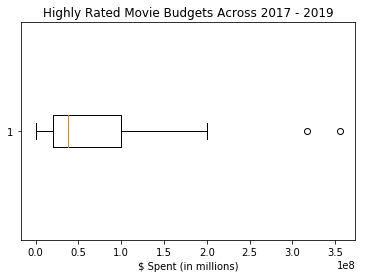

In [364]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

results1 = [x[0] for x in results]


fig, ax = plt.subplots()
ax.boxplot(results1, vert = False)
ax.set_xlabel('$ Spent (in millions)')
ax.set_title('Highly Rated Movie Budgets Across 2017 - 2019')

#plt.show()

plt.savefig('f', dpi=500)


In [353]:
mean = np.mean(results1)
mean

58686946.902654864

In [285]:
quartiles = np.percentile(results1, [25, 50, 75])

In [286]:
quartiles

array([2.0e+07, 3.8e+07, 1.0e+08])

In [287]:
iqr = quartiles[2] - quartiles[0]
iqr

80000000.0

In [288]:
max_not_outlier_bd = quartiles[2] + 1.5*iqr # upper bound for non-outlier max
max_not_outlier_bd

220000000.0

In [289]:
min_not_outlier_bd = quartiles[0] - 1.5*iqr # lower bound for non-outlier min
min_not_outlier_bd

-100000000.0

In [290]:
min_non_outlier = min(results1)
min_non_outlier

100000

In [291]:
max_result_options = [x for x in results1 if x < max_not_outlier_bd]
max_not_outlier = max(max_result_options)
max_not_outlier

200000000

In [370]:
import mysql.connector
import config

cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password)

# Establish cursor
cursor = cnx.cursor()
cursor.execute("SELECT * FROM Mod_1_Project.main_movie_table WHERE budget > 55000000 and budget < 75000000 and rt_rating > 75, releasedate")
print(cursor.fetchall())
cursor.close()
cnx.close()

[(670, 'First Man', 'First Man', 59000000, 0, datetime.date(2018, 10, 12), 24, 162, 87, 7.3), (1746, None, 'Hellboy', 66000000, 59623958, datetime.date(2004, 4, 2), 1, 1, 81, 6.9), (1747, None, 'Inglourious Basterds', 70000000, 120540719, datetime.date(2009, 8, 21), 131, 170, 88, 8.3), (1757, None, 'The Matrix', 63000000, 171479930, datetime.date(1999, 3, 31), 41, 49, 88, 8.7), (1778, None, 'Jurassic Park', 63000000, 357067947, datetime.date(1993, 6, 11), 40, 26, 91, 8.1), (1857, None, 'Total Recall', 65000000, 119394840, datetime.date(1990, 6, 1), 8, 16, 82, 7.5), (1870, None, 'Fight Club', 63000000, 37030102, datetime.date(1999, 10, 15), 10, 38, 79, 8.8), (1875, None, 'Saving Private Ryan', 70000000, 216540909, datetime.date(1998, 7, 24), 79, 74, 93, 8.6), (1895, None, 'Spy', 65000000, 110825712, datetime.date(2015, 6, 5), 6, 29, 95, 7.0), (1940, None, 'Braveheart', 72000000, 75609945, datetime.date(1995, 5, 24), 31, 30, 77, 8.4), (1953, None, 'Gone Girl', 61000000, 167767189, dateti

In [293]:
five_num_sum = [min_non_outlier, quartiles[0], quartiles[1], quartiles[2], max_not_outlier]

In [294]:
five_num_sum

[100000, 20000000.0, 38000000.0, 100000000.0, 200000000]

In [295]:
results

[(317000000, 'Star Wars: The Last Jedi'),
 (34000000, 'Baby Driver'),
 (4000000, 'Get Out'),
 (50000000, 'American Made'),
 (100000000, 'Dunkirk'),
 (25000000, 'Going in Style'),
 (149000000, 'Wonder Woman'),
 (150000000, 'War for the Planet of the Apes'),
 (29000000, 'Logan Lucky'),
 (19000000, 'Girls Trip'),
 (200000000, 'Guardians of the Galaxy Vol. 2'),
 (11000000, 'Wind River'),
 (35000000, 'It'),
 (9000000, 'Split'),
 (150000000, 'Blade Runner 2049'),
 (50000000, 'The Post'),
 (90000000, 'Jumanji: Welcome to the Jungle'),
 (180000000, 'Thor: Ragnarok'),
 (30000000, 'Atomic Blonde'),
 (80000000, 'The Lego Batman Movie'),
 (97000000, 'Logan'),
 (38000000, 'Captain Underpants: The First Epic Movie'),
 (175000000, 'Spider-Man: Homecoming'),
 (1000000, 'An Inconvenient Sequel: Truth to Power'),
 (250000, 'Sleight'),
 (34000000, 'Detroit'),
 (38000000, 'Only the Brave'),
 (2000000, 'All Saints'),
 (20000000, 'Thank You for Your Service'),
 (18000000, 'T2 Trainspotting'),
 (100000, 'A G

In [361]:
# connect to AWS
import mysql.connector
import config

cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password)

# Establish cursor
cursor = cnx.cursor()
cursor.execute("""SELECT RT_rating, IMDB_rating, omdb_title
                    FROM Mod_1_Project.main_movie_table 
                    JOIN Mod_1_Project.movies_genres USING(movie_id)
                    JOIN Mod_1_Project.genres USING(genre_id)
                    WHERE genre = 'Comedy' and RT_rating > 0 
                        and IMDB_rating > 0""")
results = cursor.fetchall()
cursor.close()
cnx.close()

In [362]:
len(results)

270

In [345]:
rt_results = [x[0] for x in results]
imdb_results = [x[1]*10 for x in results]

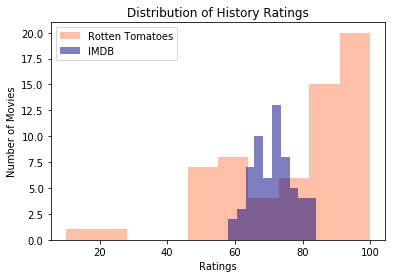

In [346]:
fig, ax = plt.subplots()

ax.hist(rt_results, alpha=0.5, label='Rotten Tomatoes', color = 'coral')
ax.hist(imdb_results, alpha=0.5, label='IMDB', color = 'navy')
ax.set_xlabel("Ratings")
ax.set_ylabel("Number of Movies")
ax.set_title("Distribution of History Ratings")
ax.legend()
plt.savefig("docRatingHistory", dpi=500)
figsize = plt.rcParams['figure.figsize']

In [341]:
figsize

[6.0, 4.0]

In [371]:
def five_num_sum(data):
    # get quartiles and the IQR
    q = np.percentile(data, [25, 50, 75])
    iqr = q[2] - q[0]
    
    # define what it means to be a lower or upper outlier
    max_not_outlier_bd = quartiles[2] + 1.5*iqr # upper bound for non-outlier max
    min_not_outlier_bd = quartiles[0] - 1.5*iqr # lower bound for non-outlier min
    
    # get the non-outlier min and max
    min_non_outlier = min(results1)
    max_result_options = [x for x in results1 if x < max_not_outlier_bd]
    max_not_outlier = max(max_result_options)
    
    # voila! your five number summary!
    return [min_non_outlier, q[0], q[1], q[2], max_non_outlier]
